In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [3]:
df = pd.read_csv('/content/retail_sales_dataset.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day_of_Week'] = df['Date'].dt.dayofweek

In [5]:
daily_sales = df.groupby('Date').agg({
    'Customer ID': 'nunique',  # Number of unique customers
    'Total Amount': 'sum'  # Total sales
}).reset_index()
daily_sales.rename(columns={'Customer ID': 'Customer_Count', 'Total Amount': 'Sales'}, inplace=True)

daily_sales = daily_sales.merge(df[['Date', 'Month', 'Week', 'Day_of_Week']].drop_duplicates(), on='Date')

In [6]:
X = daily_sales[['Customer_Count', 'Month', 'Week', 'Day_of_Week']]
y = daily_sales['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
}

In [8]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2})
    print(f'{name} -> MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}')

Linear Regression -> MAE: 676.6592018587221, RMSE: 857.5622276611282, R2 Score: 0.47787992497965903
Random Forest -> MAE: 757.722463768116, RMSE: 996.7275650957683, R2 Score: 0.29467050960575425
AdaBoost -> MAE: 818.1652238011665, RMSE: 1058.9048211415252, R2 Score: 0.20392688807103787
XGBoost -> MAE: 704.2897338867188, RMSE: 996.7244478791519, R2 Score: 0.29467499256134033


/tmp/ipython-input-9-2544908766.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')


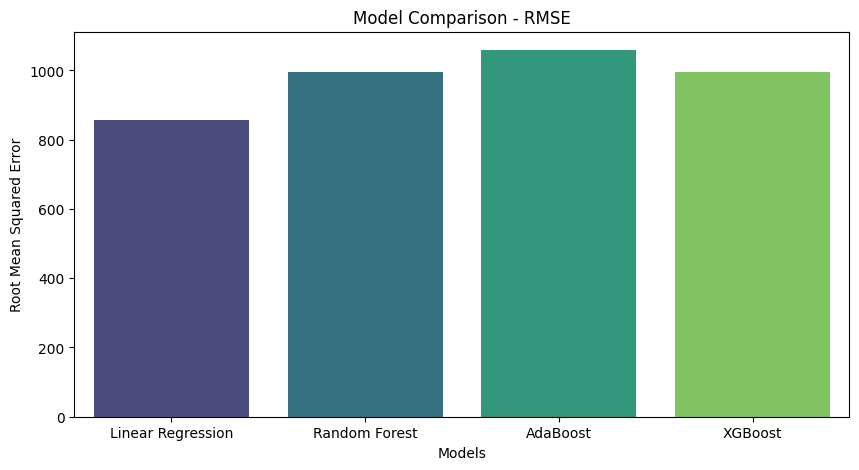

In [9]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Models')
plt.show()

In [10]:
last_month = daily_sales['Date'].max().month
last_month_data = daily_sales[daily_sales['Month'] == last_month]
last_month_X = last_month_data[['Customer_Count', 'Month', 'Week', 'Day_of_Week']]

best_model = models['XGBoost']  # Assuming XGBoost is the best performing model
predicted_revenue = best_model.predict(last_month_X)
last_month_data['Predicted_Sales'] = predicted_revenue

/tmp/ipython-input-10-724758206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_month_data['Predicted_Sales'] = predicted_revenue


In [11]:
mae_last_month = mean_absolute_error(last_month_data['Sales'], last_month_data['Predicted_Sales'])
mse_last_month = mean_squared_error(last_month_data['Sales'], last_month_data['Predicted_Sales'])
rmse_last_month = np.sqrt(mse_last_month)
r2_last_month = r2_score(last_month_data['Sales'], last_month_data['Predicted_Sales'])

print(f'Last Month Prediction Accuracy -> MAE: {mae_last_month}, RMSE: {rmse_last_month}, R2 Score: {r2_last_month}')

Last Month Prediction Accuracy -> MAE: 189.59323120117188, RMSE: 263.48791777328233, R2 Score: 0.9396040439605713


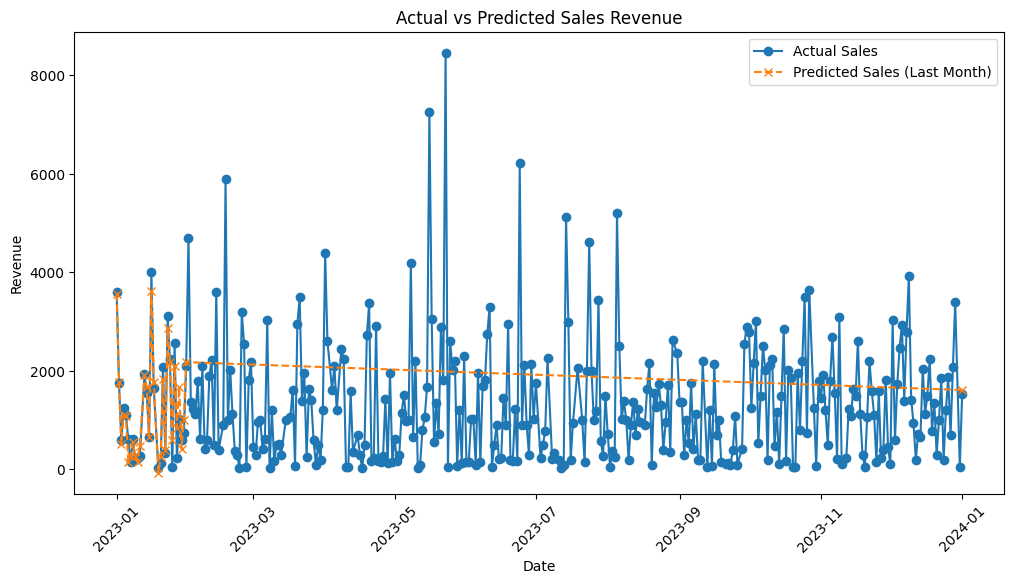

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Actual Sales', marker='o')
plt.plot(last_month_data['Date'], last_month_data['Predicted_Sales'], label='Predicted Sales (Last Month)', linestyle='dashed', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Sales Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.show()